In [81]:
%matplotlib inline
import matplotlib.style as style
style.use('ggplot')

import os, sys
import seaborn
import pandas as pd
import numpy as np
import stochastic
from scipy import stats
from matplotlib import pyplot as plt
import graphs
plt.rcParams['figure.figsize'] = [10, 6]

def load_data(res_dir):
    data = pd.DataFrame()
    for filename in os.listdir(res_dir):
        if ".csv" in filename:
            data = pd.concat([data, pd.read_csv(os.path.join(res_dir, filename))])
            
    # exclude three acyclic graphs that might be included by accident
    data = data[~(data.graph_name.str.contains("VEGF") |
                          data.graph_name.str.contains("Toll Pathway") | data.graph_name.str.contains("Processing of Spz"))]

    return data

def treat_unequal_representation(data, min_threshold=0.8, ignore_multiple_bio=False):
    # TODO: rewrite this horror of a code
    res_data = pd.DataFrame()
    n_rnds = []
    print "#original graphs={}".format(len(data.graph_name.unique()))
    for graph_name in data.graph_name.unique():
        n_bio = len(data.loc[(data.graph_name == graph_name) & (data.is_random == False)])
        n_rnd = len(data.loc[(data.graph_name == graph_name) & (data.is_random == True)])
        if n_bio > 1:
            print "Warning - too many bio for graph {}: #bio={}, #rnd={}".format(graph_name, n_bio, n_rnd)
            if ignore_multiple_bio:
                res_data = pd.concat([res_data, data[data.graph_name == graph_name]])
        elif n_bio == 1:
            res_data = pd.concat([res_data, data[data.graph_name == graph_name]])
        n_rnds.append(n_rnd)
    
    print "#original graphs with bio={}".format(len(res_data.graph_name.unique()))

    final_res_data = pd.DataFrame()
    actual_threshold = min([n for n in n_rnds if n >= (max(n_rnds) * min_threshold)])
    for graph_name in res_data.graph_name.unique():
        n_rnd = len(res_data.loc[(res_data.graph_name == graph_name) & (res_data.is_random == True)])
        if n_rnd >= actual_threshold:
            final_res_data = pd.concat([final_res_data, res_data.loc[(res_data.is_random == False) & (
                res_data.graph_name == graph_name)]])
            final_res_data = pd.concat([final_res_data, res_data.loc[(res_data.is_random == True) & (
                res_data.graph_name == graph_name)].sample(actual_threshold)])
    
    return final_res_data

def convert_model_addition_scores(data, K=30): 
    # because I have to ways to normalize that, and want to be able to convert here from 1/K to 1/ATT
    data['optimization_model_addition_impact_score'] = data['optimization_model_addition_impact_score'] * K / data['num_attractors']
    return data

def extract_vertex_scores_data(list_data):
    res_data = []
    score_cols = [col for col in list_data.columns if "scores" in col]
    non_score_cols = [col for col in list_data if col not in score_cols]
    for index, row in list_data.iterrows():
        val_lists = [eval(str(val_list).
                          replace("nan", "np.nan")) for val_list in row[score_cols]]
        for vals in zip(*val_lists):
            if not np.isnan(vals[0]):
                res_data.append(list(row[non_score_cols]) + list(vals))
    res_data = pd.DataFrame(res_data)
    res_data.columns = non_score_cols + score_cols
    res_data = res_data.rename(columns={"optimization_model_impact_scores": "optimization_model_impact_score",
                                       "stochastic_model_impact_scores": "stochastic_model_impact_score"})
    return res_data


In [74]:
data = treat_unequal_representation(load_data("results/graph_impact_1_bit"), min_threshold=0.20)
mean_data = data # TODO: refactor nicely

score_types = [col for col in data if "score" in col]
print "number of graphs: {}".format(len(data.graph_name.unique()))
print "#bio={}, #rnd={}".format(len(data.loc[data.is_random == False]), len(data.loc[data.is_random == True]))


vertex_data = treat_unequal_representation(load_data("results/29_10_pooled"), min_threshold=0.5)
print "number of graphs: {}".format(len(vertex_data.graph_name.unique()))
print "#bio={}, #rnd={}".format(len(vertex_data.loc[vertex_data.is_random == False]), len(vertex_data.loc[vertex_data.is_random == True]))
vertex_data = extract_vertex_scores_data(vertex_data)


#original graphs=37
#original graphs with bio=32
number of graphs: 26
#bio=26, #rnd=260
#original graphs=30
#original graphs with bio=28
number of graphs: 20
#bio=20, #rnd=220


## mean

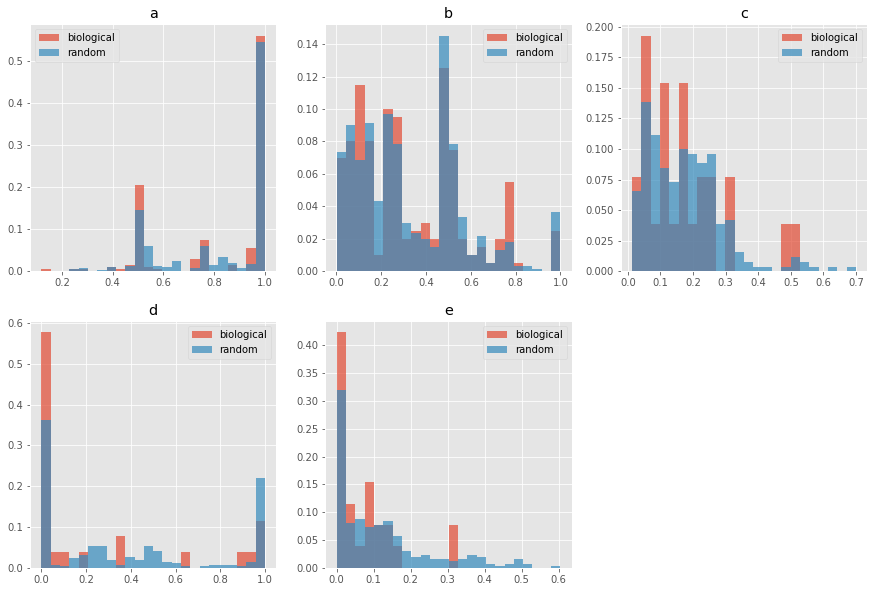

In [70]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharey=False, sharex=False, figsize=(15, 10))
fig.delaxes(ax[1,2]) #The indexing is zero-based here

# fig, ax = plt.subplots(nrows=1, ncols=3, sharey=False, sharex=False, figsize=(15, 4))

i = 0
for container, score in zip([vertex_data] * 2 + [mean_data] * 3, score_types[:2] + score_types[1:]):
    bins = np.linspace(min(container[score]), max(container[score]), 25)
    cur_ax = ax[i / 3, i % 3]
    for is_random in [False, True]:
        bar_data = container.loc[container.is_random == is_random][score].values
        weights = np.ones_like(bar_data) / float(len(bar_data))
        cur_ax.hist(bar_data, alpha=0.7, bins=bins, weights=weights)
    cur_ax.legend(["biological", "random"])
    cur_ax.set_title(['a', 'b', 'c', 'd', 'e'][i])
#     cur_ax.set_title(score.replace("_", " "))
    i += 1
plt.savefig("mean_score_histograms_israndom.png")
plt.show()

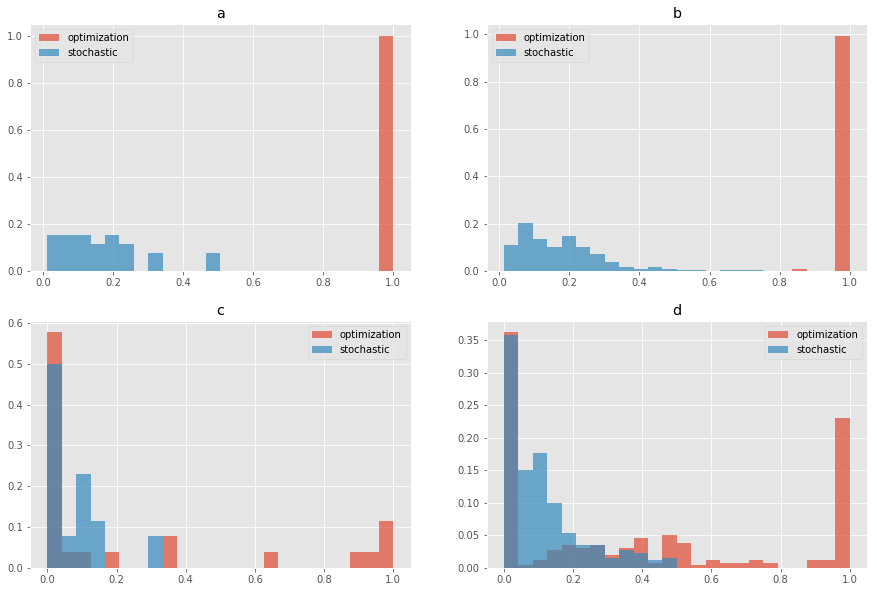

In [5]:
fig, ax = plt.subplots(nrows=len(score_types)/2, ncols=2, sharey=False, sharex=False, figsize=(15, 10))

i = 0
score_pairs = [(s, s.replace("optimization", "stochastic")) for s in score_types if "optimization" in s]
for score_pair in score_pairs:
    for is_random in [False, True]:
        bins = np.linspace(min(min(mean_data[score_pair[0]]), min(mean_data[score_pair[1]])), 
                           max(max(mean_data[score_pair[0]]), max(mean_data[score_pair[1]])), 25)
        cur_ax = ax[i / 2, i % 2]
        for score in score_pair:
            bar_data = mean_data.loc[mean_data.is_random == is_random][score].values
            weights = np.ones_like(bar_data) / float(len(bar_data))
            cur_ax.hist(bar_data, alpha=0.7, bins=bins, weights=weights)
        cur_ax.legend(["optimization", "stochastic"])
        cur_ax.set_title(['a', 'b', 'c', 'd'][i])
#         cur_ax.set_title("{}, {}".format(score_pair[0].replace("optimization", " ").replace("_", " "), 
#                                          "random" if is_random else "biological"))
        i += 1
plt.savefig("mean_score_histograms_method.png")
plt.show()

('optimization_model_impact_score', 'stochastic_model_impact_score'): 0.15
('optimization_state_impact_score', 'stochastic_state_impact_score'): 0.73


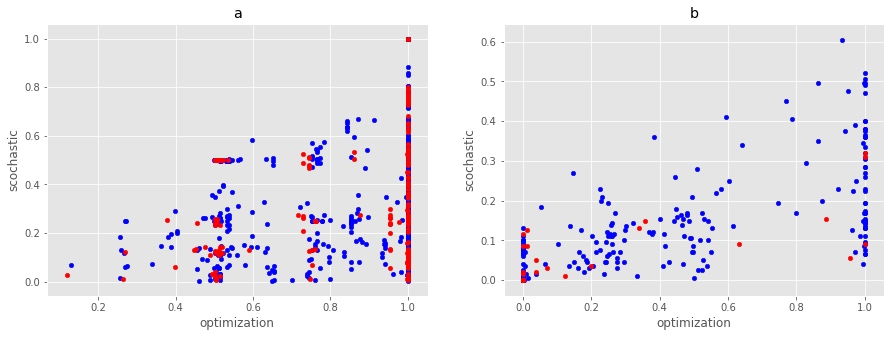

In [71]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=False, sharex=False, figsize=(15, 5))

i = 0
score_pairs = [(s, s.replace("optimization", "stochastic")) for s in score_types if "optimization" in s]
for score_pair in score_pairs:
    cur_ax = ax[i]
    container = vertex_data if "model" in score_pair[0] else mean_data
    container.loc[container.is_random == True].plot.scatter(x=score_pair[0], y=score_pair[1], c="blue", ax=cur_ax)
    container.loc[container.is_random == False].plot.scatter(x=score_pair[0], y=score_pair[1], c="red", ax=cur_ax)
    type_description = score_pair[0].replace("optimization", " ").replace("_", " ")
    correlation = np.corrcoef(container[score_pair[0]], container[score_pair[1]])[0, 1]
    print "{}: {:.2f}".format(score_pair, correlation)
#     cur_ax.set_title("{} (correlation: {:.2f})".format(type_description, correlation))
    cur_ax.set_title(['a', 'b', 'c', 'd'][i])
    cur_ax.set_xlabel("optimization")
    cur_ax.set_ylabel("scochastic")
    i += 1
plt.savefig("mean_scatter_score_types.png")
plt.show()

In [72]:
mean_pvalue_data = []
for score in score_types:
    bio = mean_data.loc[mean_data.is_random == False]
    rnd = mean_data.loc[mean_data.is_random == True]
    
    n_passed = 0
    graph_names = mean_data['graph_name'].unique()
    for graph_name in graph_names:
        graph_bio = bio.loc[bio.graph_name == graph_name][score]
        graph_rnd = rnd.loc[rnd.graph_name == graph_name][score]
        p_value = (np.argsort(list(graph_rnd) + list(graph_bio))[-1] + 1) / float(len(graph_rnd) + 1)
#         print p_value
        if p_value < 0.05:
            n_passed += 1
    proportion_passed = n_passed / float(len(graph_names))
#     row = score.replace("_", " ").replace(" impact score", ""), np.nanmean(bio[score]), np.nanmean(rnd[score]), stats.mannwhitneyu(bio[score], rnd[score])[1], proportion_passed
    row = score.replace("_", " ").replace(" impact score", ""), np.nanmean(bio[score]), np.nanmean(rnd[score]), stats.mannwhitneyu(bio[score], rnd[score])[1]
    mean_pvalue_data.append(row)
mean_pvalue_data = pd.DataFrame(mean_pvalue_data)
mean_pvalue_data.columns = ["impact variant", "real mean", "random mean", "p-value (MWW test)"]
#                             "significant ratio (sorting test)"]
mean_pvalue_data = mean_pvalue_data.set_index(mean_pvalue_data.columns[0])
mean_pvalue_data.to_csv("mean_pvalues.csv", float_format="%.3g")
mean_pvalue_data


,real mean,random mean,p-value (MWW test)
impact variant,,,
optimization model,1.000000,0.999997,0.353082
stochastic model,0.171816,0.174043,0.350860
optimization state,0.256428,0.389182,0.061014
stochastic state,0.072692,0.118365,0.062978


In [73]:
mean_pvalue_data = []
for score in score_types:
    bio = mean_data.loc[mean_data.is_random == False]
    rnd = mean_data.loc[mean_data.is_random == True]
    graph_names = mean_data['graph_name'].unique()
    mean_pairs = []
    pairs = []
    ranks = []
    samples_per_graph = None
    for graph_name in graph_names:
        graph_bio = bio.loc[bio.graph_name == graph_name][score].values[0]
        graph_rnd = rnd.loc[rnd.graph_name == graph_name][score]
        if samples_per_graph is None:
            samples_per_graph = len(graph_rnd) + 1
        mean_pairs.append((graph_bio, graph_rnd.mean()))
        for rnd_point in graph_rnd:
            pairs.append((graph_bio, rnd_point))
        ranks.append(np.argsort(list(graph_rnd) + [graph_bio])[-1])

    pair_pvalue = stats.wilcoxon(zip(*pairs)[0], zip(*pairs)[1])[1]
    mean_pair_pvalue = stats.wilcoxon(zip(*mean_pairs)[0], zip(*mean_pairs)[1])[1]
    rank_counts = [len([r for r in ranks if r == i]) for i in range(samples_per_graph)]
    print rank_counts
    rank_pvalue = stats.chisquare(f_obs=rank_counts)[1]
    row = score.replace("_", " ").replace(" impact score", ""), pair_pvalue, mean_pair_pvalue, rank_pvalue
    mean_pvalue_data.append(row)
mean_pvalue_data = pd.DataFrame(mean_pvalue_data)
mean_pvalue_data.columns = ["impact variant", "p-value (Wilcoxon mean test)", "p-value (Wilcoxon test)", "p-value (rank chisquared)"]
#                             "significant ratio (sorting test)"]
mean_pvalue_data = mean_pvalue_data.set_index(mean_pvalue_data.columns[0])
# mean_pvalue_data.to_csv("mean_pvalues.csv", float_format="%.3g")
mean_pvalue_data


[0, 1, 1, 0, 2, 0, 0, 1, 0, 0, 21]
[4, 1, 4, 1, 3, 0, 3, 2, 1, 4, 3]
[2, 4, 1, 2, 3, 3, 4, 2, 0, 4, 1]
[3, 5, 1, 0, 1, 2, 6, 3, 0, 5, 0]


c:\python27\lib\site-packages\scipy\stats\morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


,p-value (Wilcoxon mean test),p-value (Wilcoxon test),p-value (rank chisquared)
impact variant,,,
optimization model,2.971465e-01,0.179712,6.021783e-30
stochastic model,2.228197e-02,0.081901,5.615323e-01
optimization state,2.846383e-08,0.011501,6.438614e-01
stochastic state,2.802064e-07,0.004626,2.455197e-02


In [97]:
# good cols = [col for col in data.columns if (col not in score_types) and (
#     col not in timing_types) and (
#     col not in ["is_random", "maximal_change_bits", "median_attractor_length", "max_attractor_length"]) and (
#     "std" not in col)]

threshold = 0.3
bio_rows = []
rnd_rows = []
property_columns = [col for col in data.columns if ("score" not in col) and ("time" not in col) and data[col].dtype in [np.int, np.float, np.int64]]
for score, container in zip(score_types[:2] + score_types[1:], [vertex_data]*2 + [mean_data]*3):
    print score
    bio = container.loc[container.is_random == False]
    rnd = container.loc[container.is_random == True]
    rnd_rows.append([None] * (len(property_columns) + 1))
    bio_rows.append([None] * (len(property_columns) + 1))
    for i, field in enumerate(property_columns):
        bio_corr = np.corrcoef(bio[score], bio[field])[1,0]
        rnd_corr = np.corrcoef(rnd[score], rnd[field])[1,0]
        
        bio_rows[-1][0] = score 
        rnd_rows[-1][0] = score
        bio_rows[-1][i + 1] = bio_corr
        rnd_rows[-1][i + 1] = rnd_corr
        if field == score:
            continue
        if abs(bio_corr) >= threshold or abs(rnd_corr) >= threshold:
            print "{}\t biological corr={:.2f}\t random corr={:.2f}".format(field, bio_corr, rnd_corr)
    print ""

bio_rows_df = pd.DataFrame(bio_rows)
bio_rows_df.columns = ["score"] + property_columns
bio_rows_df.index.name = "score variant"
bio_rows_df = bio_rows_df.set_index("score")
bio_rows_df.to_csv("bio_corr.csv", float_format="%.3g")

rnd_rows_df = pd.DataFrame(rnd_rows)
rnd_rows_df.columns = ["score"] + property_columns
rnd_rows_df.index.name = "score variant"
rnd_rows_df = rnd_rows_df.set_index("score")
rnd_rows_df.to_csv("rnd_corr.csv", float_format="%.3g")
print rnd_rows_df


optimization_model_impact_score
n_inputs	 biological corr=-0.44	 random corr=-0.39
normalized_n_inputs	 biological corr=-0.48	 random corr=-0.42
num_attractors	 biological corr=-0.35	 random corr=-0.30
mean_attractor_length	 biological corr=0.45	 random corr=0.22
median_attractor_length	 biological corr=0.46	 random corr=0.21
std_attractor_length	 biological corr=0.39	 random corr=0.09
max_attractor_length	 biological corr=0.42	 random corr=0.15
median_attractor_basin	 biological corr=0.50	 random corr=0.29
max_attractor_basin	 biological corr=0.53	 random corr=0.42

stochastic_model_impact_score
size	 biological corr=0.33	 random corr=0.14
mean_degree	 biological corr=-0.34	 random corr=-0.24
mean_attractor_length	 biological corr=0.47	 random corr=0.23
median_attractor_length	 biological corr=0.47	 random corr=0.22
std_attractor_length	 biological corr=0.47	 random corr=0.16
max_attractor_length	 biological corr=0.49	 random corr=0.23

stochastic_model_impact_score
max_degree	 biolog

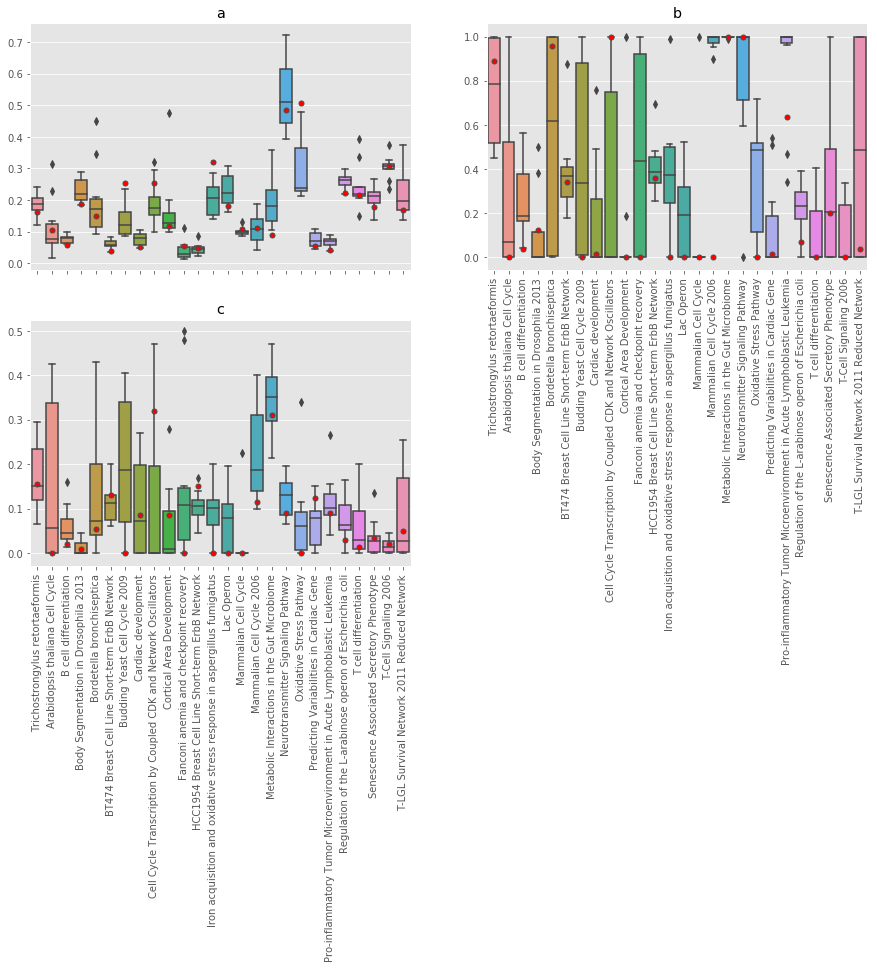

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharey=False, sharex=True, figsize=(15, 13))
fig.delaxes(ax[1,1]) #The indexing is zero-based here

i = 0
for score in score_types[1:]:
    bins = np.linspace(min(mean_data[score]), max(mean_data[score]), 25)
    cur_ax = ax[i / 2, i % 2]
    g = seaborn.boxplot(ax=cur_ax, data=mean_data.loc[mean_data.is_random == True], 
                    x="graph_name", y=score, hue="graph_name", dodge=False)
    bio = mean_data.loc[mean_data.is_random == False]
    seaborn.swarmplot(ax=cur_ax, x="graph_name", y=score, data=bio,
              size=5, color="red", marker="o", linewidth=1)

    cur_ax.xaxis.set_tick_params(rotation=90)
    cur_ax.set_ylabel("")
    cur_ax.set_xlabel("")
    cur_ax.legend_.remove()
#     cur_ax.set_title(score.replace("_", " ").replace(" score", ""))
    cur_ax.set_title(['a', 'b', 'c','d', 'e'][i])
    
    i += 1
ax[0, 1].xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False)

plt.gcf().subplots_adjust(bottom=0.3)

plt.savefig("mean_graph_score.png")
plt.show()

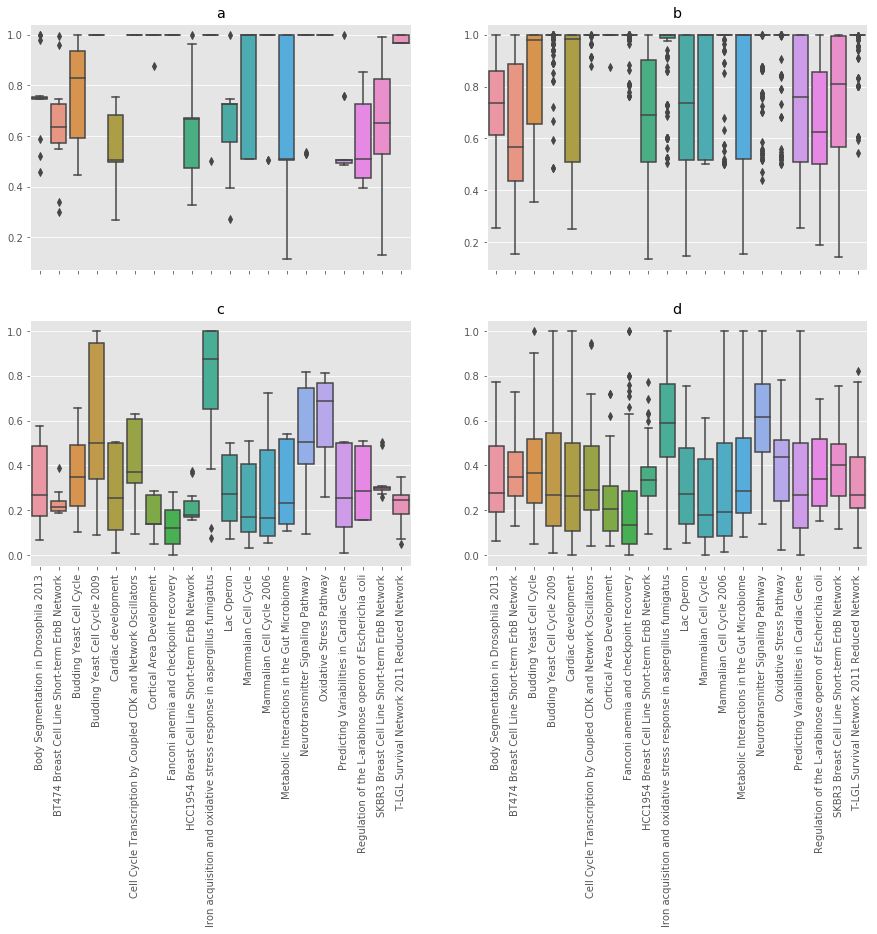

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharey=False, sharex=True, figsize=(15, 13))

i = 0
for score in score_types[:2]:
    for is_random in [False, True]:
        bins = np.linspace(min(vertex_data[score]), max(vertex_data[score]), 25)
        cur_ax = ax[i / 2, i % 2]
        g = seaborn.boxplot(ax=cur_ax, data=vertex_data.loc[vertex_data.is_random == is_random], 
                        x="graph_name", y=score, hue="graph_name", dodge=False)
        
        cur_ax.xaxis.set_tick_params(rotation=90)
        cur_ax.set_ylabel("")
        cur_ax.set_xlabel("")
        cur_ax.legend_.remove()
    #     cur_ax.set_title(score.replace("_", " ").replace(" score", ""))
        cur_ax.set_title(['a', 'b', 'c','d', 'e'][i])
        i += 1

plt.gcf().subplots_adjust(bottom=0.3)

plt.savefig("vertex_graph_scores.png")
plt.show()

## More bits

In [82]:
more_bits_data = treat_unequal_representation(load_data("results/graph_impact_multiple_bits"), min_threshold=0.20,
                                             ignore_multiple_bio=True)
print "number of graphs: {}".format(len(more_bits_data.graph_name.unique()))
print "#bio={}, #rnd={}".format(len(more_bits_data.loc[more_bits_data.is_random == False]), len(more_bits_data.loc[more_bits_data.is_random == True]))

#original graphs=37
Warning - too many bio for graph FA BRCA pathway: #bio=4, #rnd=1
Warning - too many bio for graph Arabidopsis thaliana Cell Cycle: #bio=4, #rnd=39
Warning - too many bio for graph B cell differentiation: #bio=4, #rnd=48
Warning - too many bio for graph Body Segmentation in Drosophila 2013: #bio=4, #rnd=54
Warning - too many bio for graph Bordetella bronchiseptica: #bio=4, #rnd=41
Warning - too many bio for graph Budding Yeast Cell Cycle 2009: #bio=4, #rnd=45
Warning - too many bio for graph Cardiac development: #bio=4, #rnd=54
Warning - too many bio for graph Cell Cycle Transcription by Coupled CDK and Network Oscillators: #bio=4, #rnd=54
Warning - too many bio for graph Cortical Area Development: #bio=4, #rnd=54
Warning - too many bio for graph Fanconi anemia and checkpoint recovery: #bio=4, #rnd=50
Warning - too many bio for graph Human Gonadal Sex Determination: #bio=4, #rnd=0
Warning - too many bio for graph Iron acquisition and oxidative stress response in aspe

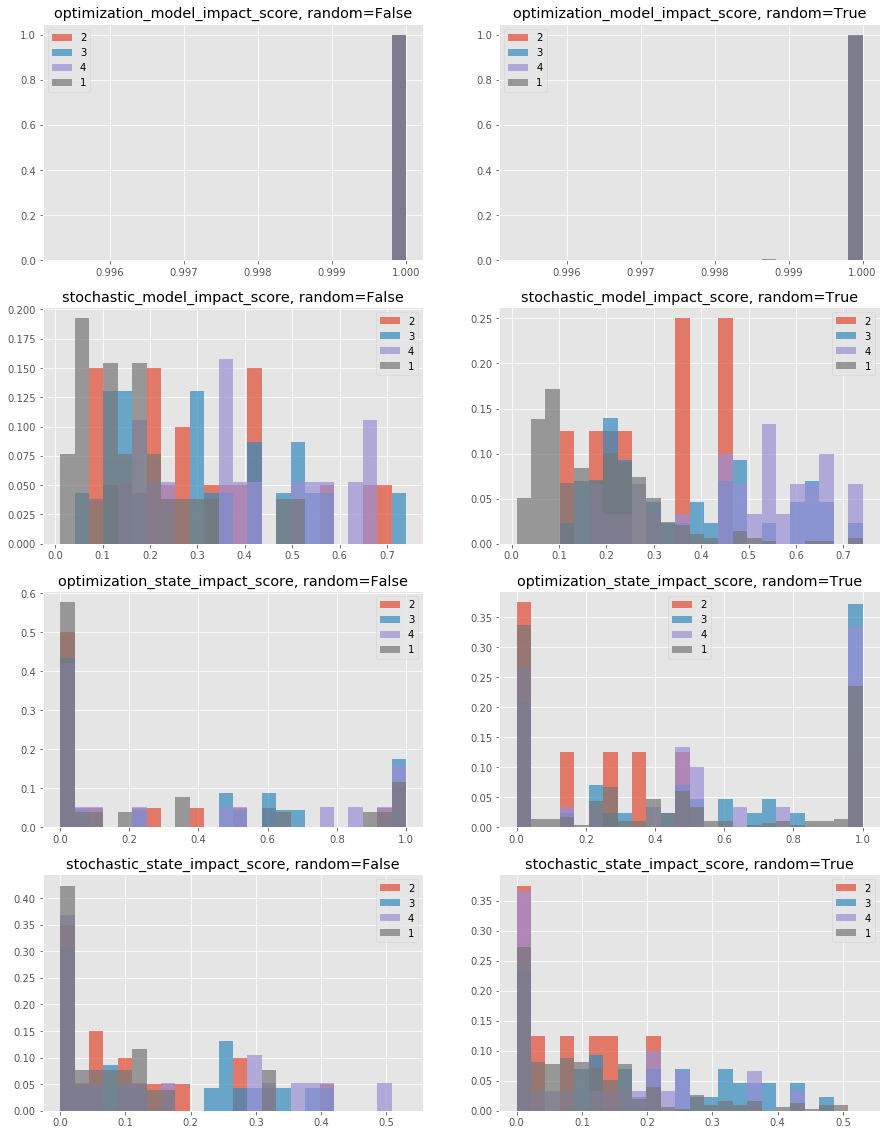

In [85]:
fig, ax = plt.subplots(nrows=len(score_types), ncols=2, sharey=False, sharex=False, figsize=(15, 20))

i = 0
for score in score_types:
    bins = np.linspace(min(mean_data[score]), max(mean_data[score]), 25)
    for is_random in [False, True]:
        cur_ax = ax[i / 2, i % 2]
        for n_bits in more_bits_data.maximal_change_bits.unique():
            bits = more_bits_data.loc[more_bits_data.maximal_change_bits == n_bits]
            bar_data = bits.loc[bits.is_random == is_random][score].values
            weights = np.ones_like(bar_data) / float(len(bar_data))
            cur_ax.hist(bar_data, alpha=0.7, bins=bins, weights=weights)
        cur_ax.legend(more_bits_data.maximal_change_bits.unique())
    #         cur_ax.set_title(['a', 'b', 'c', 'd'][i])
        cur_ax.set_title("{}, random={}".format(score, is_random))
    #     cur_ax.set_title(score.replace("_", " "))
        i += 1
plt.savefig("2_bit_score_histograms.png")
plt.show()

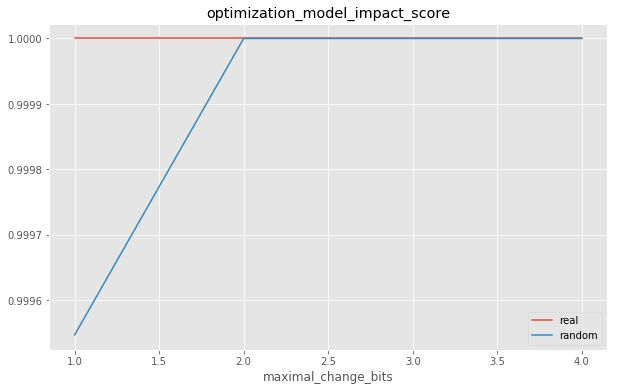

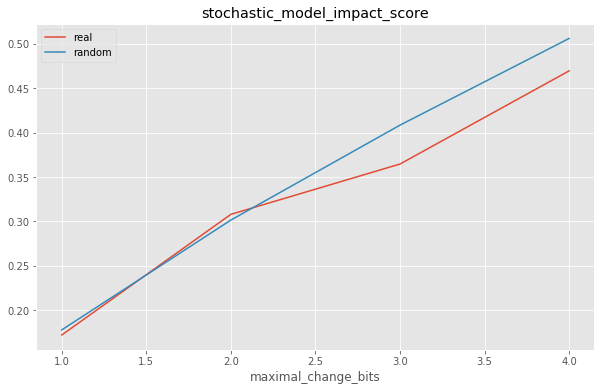

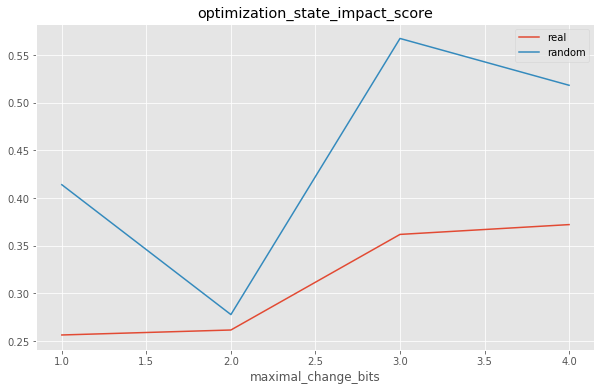

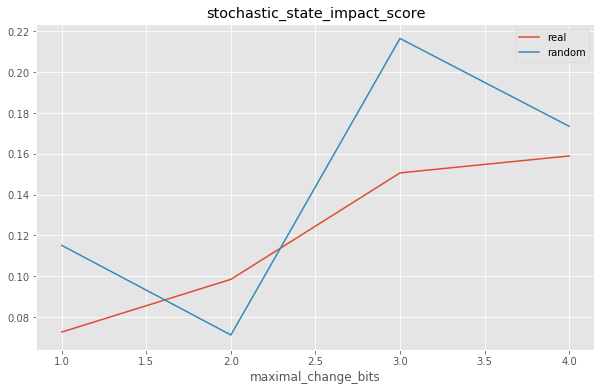

In [96]:
# fig, ax = plt.subplots(nrows=len(score_types), ncols=2, sharey=False, sharex=False, figsize=(15, 20))

# i = 0
for score in score_types:
#     bins = np.linspace(min(mean_data[score]), max(mean_data[score]), 25)
    for is_random in [False, True]:
#         cur_ax = ax[i / 2, i % 2]
        more_bits_data.loc[more_bits_data.is_random == is_random].groupby('maximal_change_bits')[score].mean().plot()
    plt.legend(["real", "random"])
    plt.title("{}".format(score))
    plt.show()
#         for n_bits in more_bits_data.maximal_change_bits.unique():
#             bits = more_bits_data.loc[more_bits_data.maximal_change_bits == n_bits]
#             bar_data = bits.loc[bits.is_random == is_random][score].values
#             weights = np.ones_like(bar_data) / float(len(bar_data))
#             cur_ax.hist(bar_data, alpha=0.7, bins=bins, weights=weights)
#         cur_ax.legend(more_bits_data.maximal_change_bits.unique())
#     #         cur_ax.set_title(['a', 'b', 'c', 'd'][i])
#         cur_ax.set_title("{}, random={}".format(score, is_random))
#     #     cur_ax.set_title(score.replace("_", " "))
#         i += 1
# plt.savefig("2_bit_score_histograms.png")
# plt.show()

## Timing and graph properties

In [13]:
timing_types = [score.replace("impact_score", "time") for score in score_types]
timing_data = []
for timing_type in timing_types:
    row = [np.nanmedian(data[timing_type]), np.nanmean(data[timing_type]),
                                                         np.nanmax(data[timing_type])]
    timing_data.append([timing_type.replace("_", " ").replace(" time", "")] + row)
timing_data = pd.DataFrame(timing_data)
timing_data = timing_data.set_index(timing_data.columns[0])
timing_data.columns = ["median (seconds)", "mean (seconds)", "max (seconds)"]
timing_data.index.name = "impact variant"
timing_data.to_csv("timings.csv", float_format="%.0f")
timing_data

# bins = np.linspace(0, 1000, 100)
# for timing_type in timing_types:
#     data[timing_type].hist(figsize=(20, 12), bins=bins, alpha=0.3)
# plt.legend(timing_types)
# plt.show()

# for timing_type in timing_types:
#     for graph_name in data.graph_name.unique():
#         data.loc[data.graph_name == graph_name][timing_type].hist(figsize=(20, 12), bins=bins, alpha=0.3)
#     plt.title(timing_type)
#     plt.legend(data.graph_name.unique())
#     plt.show()

# for timing_type in timing_types:
#     for field in [col for col in data.columns if ("score" not in col) and ("time" not in col) and data[col].dtype in [np.int, np.float, np.int64]]:
#         data.plot.scatter(field, timing_type)


,median (seconds),mean (seconds),max (seconds)
impact variant,,,
optimization model,0.038284,0.091159,1.218967
stochastic model,5.088573,9.849264,57.691544
optimization state,5.840388,37.065985,316.080471
stochastic state,1.320523,2.179129,10.684978


In [78]:
bio_properties = data.loc[data.is_random==False][[col for col in data.columns if (col not in score_types) and (
    col not in timing_types) and (
    col not in ["is_random", "maximal_change_bits", "median_attractor_length", "max_attractor_length", "normalized_n_inputs"]) and (
    "std" not in col)]]
rnd_properties = data.loc[data.is_random==True][[col for col in data.columns if (col not in score_types) and (
    col not in timing_types) and (
    col not in ["is_random", "maximal_change_bits", "median_attractor_length", "max_attractor_length", "normalized_n_inputs"]) and (
    "std" not in col)]]
bio_properties.to_csv("bio_graph_properties.csv", float_format='%.3g')

# rnd_properties.to_csv("rnd_graph_properties.csv", float_format='%.3g')
bio_properties

,graph_name,size,n_inputs,max_degree,mean_degree,num_attractors,mean_attractor_length,median_attractor_basin,max_attractor_basin
0,Trichostrongylus retortaeformis,26,1,5,2.230769,12,4.250000,0.015529,0.297978
2,Arabidopsis thaliana Cell Cycle,14,0,8,4.714286,1,8.000000,1.000000,1.000000
4,B cell differentiation,22,5,7,1.772727,59,1.033898,0.020148,0.039062
5,Body Segmentation in Drosophila 2013,17,3,4,1.705882,10,1.000000,0.119803,0.148860
6,Bordetella bronchiseptica,33,0,6,2.393939,4,1.250000,0.031130,0.918609
7,BT474 Breast Cell Line Short-term ErbB Network,16,5,6,2.875000,92,1.000000,0.002315,0.037809
9,Budding Yeast Cell Cycle 2009,18,0,6,3.277778,1,11.000000,1.000000,1.000000
10,Cardiac development,15,1,7,2.533333,6,1.000000,0.232841,0.280443
11,Cell Cycle Transcription by Coupled CDK and Ne...,9,0,4,2.111111,2,3.000000,0.500000,0.768707
12,Cortical Area Development,5,0,4,2.800000,2,1.000000,0.500000,0.875000


['num_attractors', 'mean_attractor_length', 'median_attractor_basin', 'max_attractor_basin']


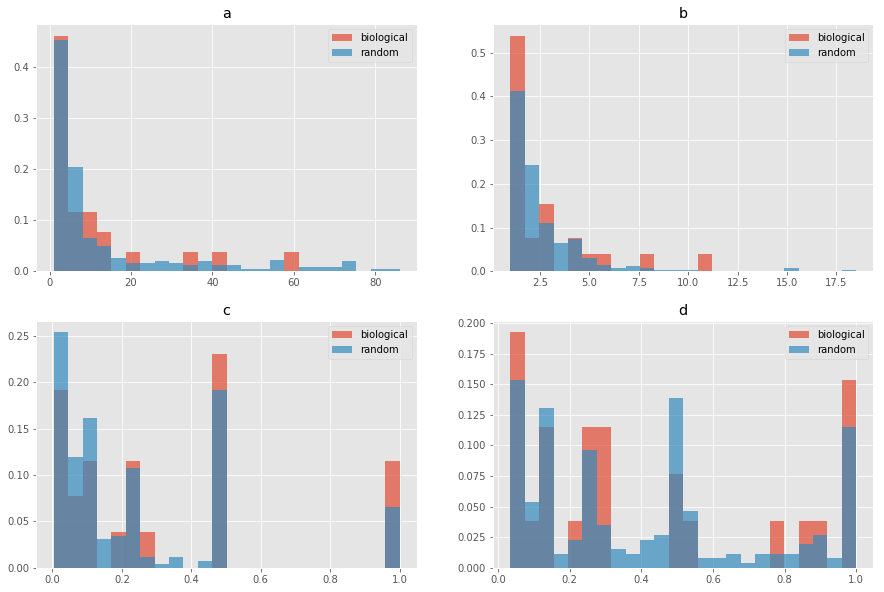

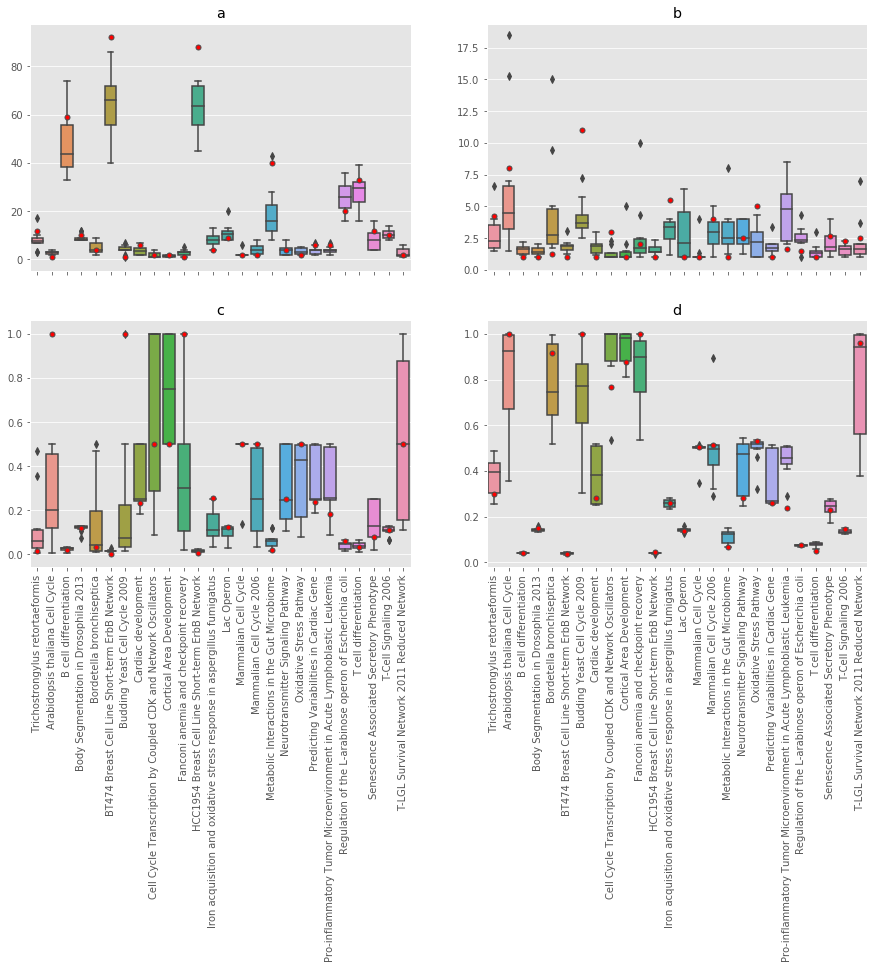

,real mean,random mean,p-value (Wilcoxon mean test)
attractor property,,,
num attractors,16.538462,13.376923,0.003170
mean attractor length,2.621817,2.572379,0.799017
median attractor basin,0.298965,0.241232,0.363196
max attractor basin,0.410143,0.405774,0.514222


In [15]:
attractor_properties = [p for p in bio_properties.columns if ("attractor" in p or "basin" in p)]
fig, ax = plt.subplots(nrows=len(attractor_properties)/2, ncols=2, sharey=False, sharex=False, figsize=(15, 10))
print attractor_properties

i = 0
for attractor_property in attractor_properties:
    bins = np.linspace(min(rnd_properties[attractor_property]), max(rnd_properties[attractor_property]), 25)
    cur_ax = ax[i / 2, i % 2]
    for is_random, container in zip([False, True], [bio_properties, rnd_properties]):
        bar_data = container[attractor_property].values
        weights = np.ones_like(bar_data) / float(len(bar_data))
        cur_ax.hist(bar_data, alpha=0.7, bins=bins, weights=weights)
    cur_ax.legend(["biological", "random"])
    cur_ax.set_title(['a', 'b', 'c', 'd', 'e', 'f', 'g'][i])
#     cur_ax.set_title(score.replace("_", " "))
    i += 1
plt.savefig("attractor_properties_hist.png")
plt.show()

fig, ax = plt.subplots(nrows=len(attractor_properties)/2, ncols=2, sharey=False, sharex=True, figsize=(15, 10))
i = 0
for attractor_property in attractor_properties:
    cur_ax = ax[i / 2, i % 2]
    g = seaborn.boxplot(ax=cur_ax, data=rnd_properties, 
                    x="graph_name", y=attractor_property, hue="graph_name", dodge=False)
    bio = bio_properties
    seaborn.swarmplot(ax=cur_ax, x="graph_name", y=attractor_property, data=bio_properties,
              size=5, color="red", marker="o", linewidth=1)

    cur_ax.xaxis.set_tick_params(rotation=90)
    cur_ax.set_ylabel("")
    cur_ax.set_xlabel("")
    cur_ax.legend_.remove()
    cur_ax.set_title(['a', 'b', 'c', 'd', 'e', 'f', 'g'][i])
    i += 1
plt.savefig("attractor_properties_graph_breakdown.png")
plt.show()

mean_pvalue_data = []
for attractor_property in attractor_properties:
    bio = bio_properties
    rnd = rnd_properties
    graph_names = mean_data['graph_name'].unique()
    mean_pairs = []
    pairs = []
    for graph_name in graph_names:
        graph_bio = bio.loc[bio.graph_name == graph_name][attractor_property].values[0]
        graph_rnd = rnd.loc[rnd.graph_name == graph_name][attractor_property]
        mean_pairs.append((graph_bio, graph_rnd.mean()))
        for rnd_point in graph_rnd:
            pairs.append((graph_bio, rnd_point))

    bio_mean = np.nanmean(bio[attractor_property])
    rnd_mean = np.nanmean(rnd[attractor_property])
    pair_pvalue = stats.wilcoxon(zip(*pairs)[0], zip(*pairs)[1])[1]
    mean_pair_pvalue = stats.wilcoxon(zip(*mean_pairs)[0], zip(*mean_pairs)[1])[1]
    row = attractor_property.replace("_", " "), bio_mean, rnd_mean, pair_pvalue#, mean_pair_pvalue
    mean_pvalue_data.append(row)
mean_pvalue_data = pd.DataFrame(mean_pvalue_data)
mean_pvalue_data.columns = ["attractor property", "real mean", "random mean", "p-value (Wilcoxon mean test)"]
#                             "p-value (Wilcoxon test)"]
#                             "significant ratio (sorting test)"]
mean_pvalue_data = mean_pvalue_data.set_index(mean_pvalue_data.columns[0])
mean_pvalue_data.to_csv("properties_pvalues.csv", float_format="%.3g")
mean_pvalue_data


## JUNK

In [16]:
# graph_dirs = ["Trichostrongylus retortaeformis",
# "FA BRCA pathway",
# "Apoptosis Network",
# "Arabidopsis thaliana Cell Cycle",
# "Aurora Kinase A in Neuroblastoma",
# "B bronchiseptica and T retortaeformis coinfection",
# "B cell differentiation",
# "Body Segmentation in Drosophila 2013",
# "Bordetella bronchiseptica",
# "BT474 Breast Cell Line Short-term ErbB Network",
# "Budding Yeast Cell Cycle",
# "Budding Yeast Cell Cycle 2009",
# "Cardiac development",
# "Cell Cycle Transcription by Coupled CDK and Network Oscillators",
# "Cholesterol Regulatory Pathway",
# "Cortical Area Development",
# "Death Receptor Signaling",
# "Fanconi anemia and checkpoint recovery",
# "Toll Pathway of Drosophila Signaling Pathway",
# "Guard Cell Abscisic Acid Signaling",
# "HCC1954 Breast Cell Line Short-term ErbB Network",
# "Human Gonadal Sex Determination",
# "Iron acquisition and oxidative stress response in aspergillus fumigatus",
# "Lac Operon",
# "Lymphoid and myeloid cell specification and transdifferentiation",
# "Mammalian Cell Cycle",
# "Mammalian Cell Cycle 2006",
# "MAPK Cancer Cell Fate Network",
# "Metabolic Interactions in the Gut Microbiome",
# "Neurotransmitter Signaling Pathway",
# "Oxidative Stress Pathway",
# "Predicting Variabilities in Cardiac Gene",
# "Pro-inflammatory Tumor Microenvironment in Acute Lymphoblastic Leukemia",
# "Regulation of the L-arabinose operon of Escherichia coli",
# "T cell differentiation",
# "Senescence Associated Secretory Phenotype",
# "SKBR3 Breast Cell Line Long-term ErbB Network",
# "SKBR3 Breast Cell Line Short-term ErbB Network",
# "T-Cell Signaling 2006",
# "T-LGL Survival Network 2011 Reduced Network",
# "Tumour Cell Invasion and Migration",
# "Stomatal Opening Model",
# "T-LGL Survival Network 2011",
# "Processing of Spz Network from the Drosophila Signaling Pathway"]
biological_graphs = []
biological_graph_names = []
size_cutoff = 60
candidate_biological_graph_names = os.listdir("cellcollective_models")
# for graph_dir in candidate_biological_graph_names:
for graph_dir in graph_dirs:
    try:
        G = graphs.Network.parse_boolean_tables(os.path.join("cellcollective_models", graph_dir))
        if len(G.vertices) <= size_cutoff:
            stochastic.estimate_path_len_to_attractor(G, n_iter=100)
            biological_graphs.append(G)
            biological_graph_names.append(graph_dir)
    except ValueError as e:
        if e.message.startswith("Model export from cellcollective failed"):
            print "warning - did not load graph {}".format(graph_dir)

graph_name_to_attributes = dict()
for i, graph, name in zip(range(len(biological_graphs)), biological_graphs, biological_graph_names):
    n_inputs = len([v for v in graph.vertices if len(v.predecessors()) == 0])
    max_degree = max([len(v.predecessors()) for v in graph.vertices])
    size = len(graph.vertices)
    mean_degree = sum([len(v.predecessors()) for v in graph.vertices]) / float(size)
    normaliezd_n_inputs = n_inputs / float(size)
    graph_name_to_attributes[name] = dict(n_inputs=n_inputs, max_degree=max_degree,
                                                size=size, mean_degree=mean_degree,
                                          normalized_n_inputs=normaliezd_n_inputs, G=graph)
    print "#{}; {} input nodes for graph {} of size {} and max degree {}".format(i, n_inputs, name,
                                                                                 size, max_degree)


NameError: name 'graph_dirs' is not defined

In [52]:
good_graphs = [name for name in graph_name_to_attributes.keys() if name in data["graph_name"].unique()]
bad_graphs = [name for name in graph_name_to_attributes.keys() if name not in good_graphs]
print len(good_graphs), len(bad_graphs)

good_sizes = [graph_name_to_attributes[name]['size'] for name in good_graphs]
bad_sizes = [graph_name_to_attributes[name]['size'] for name in bad_graphs]
bins = np.linspace(0, 100, 100)
plt.hist(good_sizes, alpha=0.5, bins=bins)
plt.hist(bad_sizes, alpha=0.5, bins=bins)
plt.show()

good_edges = [graph_name_to_attributes[name]['size'] * graph_name_to_attributes[name]['mean_degree'] for name in good_graphs]
bad_edges = [graph_name_to_attributes[name]['size'] * graph_name_to_attributes[name]['mean_degree'] for name in bad_graphs]
bins = np.linspace(0, 100, 100)
plt.hist(good_edges, alpha=0.5, bins=bins)
plt.hist(bad_edges, alpha=0.5, bins=bins)
plt.show()

good_edges = [graph_name_to_attributes[name]['max_degree'] for name in good_graphs]
bad_edges = [graph_name_to_attributes[name]['max_degree'] for name in bad_graphs]
bins = np.linspace(0, 15, 20)
plt.hist(good_edges, alpha=0.5, bins=bins)
plt.hist(bad_edges, alpha=0.5, bins=bins)
plt.show()

good_attractors = [len(stochastic.estimate_attractors(
    G=graph_name_to_attributes[name]['G'], max_walk_len=50, n_walks=200, with_basins=False)) for name in good_graphs]
bad_attractors = [len(stochastic.estimate_attractors(
    G=graph_name_to_attributes[name]['G'], max_walk_len=50, n_walks=200, with_basins=False)) for name in bad_graphs if graph_name_to_attributes[name]['size'] <= 10000]
bins = np.linspace(0, 100, 100)
plt.hist(good_attractors, alpha=0.5, bins=bins)
plt.hist(bad_attractors, alpha=0.5, bins=bins)
plt.show()

NameError: name 'graph_name_to_attributes' is not defined